## Обяъвление функций

In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from tqdm import trange
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction

In [2]:
augments_per_sample = 1
batch_size = 32

In [3]:
def load_data(dataset):
    """
    if dataset == "ihb":
        close = np.load("close_mean_ts_by_network.npy")
        open = np.load("open_mean_ts_by_network.npy")
    elif dataset == "china":
        open = np.load("china_open_mean_ts_by_network_HCPex.npy")
        close = np.load("china_close_mean_ts_by_network_HCPex.npy")
    elif dataset == "china_cut":
        open = np.load("china_open_mean_ts_by_network_HCPex.npy")
        close = np.load("china_close_mean_ts_by_network_HCPex.npy")
        close = close[:, :48, :]
    else:
        print("dataset must be ihb, china or china_cut.")
        return
    """
    if dataset == "ihb":
        close = np.load("ihb_close_mean_HCPex.npy")
        open = np.load("ihb_open_mean_HCPex.npy")
    elif dataset == "china":
        open = np.load("china_open_mean_HCPex.npy")
        close = np.load("china_close_mean_HCPex.npy")
    elif dataset == "china_cut":
        open = np.load("china_open_mean_HCPex.npy")
        close = np.load("china_close_mean_HCPex.npy")
        close = close[:48]
    else:
        print("dataset must be ihb, china or china_cut.")
        return
    data = np.concatenate((close, open), axis=0)
    data = torch.tensor(data).float()
    data = data.reshape((data.shape[0], data.shape[2], data.shape[1]))
    close = close.reshape((close.shape[2], close.shape[0], close.shape[1]))
    open = open.reshape((open.shape[2], open.shape[0], open.shape[1]))
    return close, open, data

In [4]:
def load_data_old(dataset):
    if dataset == "ihb":
        close = np.load("close_mean_ts_by_network.npy")
        open = np.load("open_mean_ts_by_network.npy")
    elif dataset == "china":
        open = np.load("china_open_mean_ts_by_network_HCPex.npy")
        close = np.load("china_close_mean_ts_by_network_HCPex.npy")
    elif dataset == "china_cut":
        open = np.load("china_open_mean_ts_by_network_HCPex.npy")
        close = np.load("china_close_mean_ts_by_network_HCPex.npy")
        close = close[:, :48, :]
    else:
        print("dataset must be ihb, china or china_cut.")
        return

    data = np.concatenate((close, open), axis=1)
    data = torch.tensor(data).float()
    data = data.reshape((data.shape[1], data.shape[0], data.shape[2]))
    return close, open, data

In [5]:
def train_augmentation_transformer(data, context=20, dataset_name="ihb"):
    data = data[:data.shape[0] - data.shape[0] % 4]
    data = data.reshape((data.shape[0], data.shape[2], data.shape[1]))
    past_values = []
    future_values = []
    past_time_features = []
    future_time_features = []
    static_categorical_features = []
    for i in range(data.shape[0]):
        start = 0
        while start + 24 < data[i].shape[0]:
            past_values.append(data[i][start : start+context])
            future_values.append(data[i][start+context : start+24])
            past_time_features.append(range(start, start+context))
            future_time_features.append(range(start+context, start+24))
            static_categorical_features.append(1 - (i // (data.shape[0] // 2)))
            start += 4
    past_values = torch.stack(past_values)
    future_values = torch.stack(future_values)
    past_time_features = torch.Tensor(past_time_features)
    future_time_features = torch.Tensor(future_time_features)
    past_time_features = past_time_features.reshape((past_time_features.shape[0], past_time_features.shape[1], 1))
    future_time_features = future_time_features.reshape((future_time_features.shape[0], future_time_features.shape[1], 1))
    past_observed_mask = torch.ones(past_values.shape)
    static_categorical_features = torch.Tensor(static_categorical_features).int()

    n = past_values.shape[0]
    test_size = 0.2
    test_idx = np.random.choice(range(n), size=int(test_size * n), replace=False)
    train_idx = np.setdiff1d(range(n), test_idx)
    train_past_values = past_values[train_idx]
    test_past_values = past_values[test_idx]
    train_future_values = future_values[train_idx]
    test_future_values = future_values[test_idx]
    train_past_time_features = past_time_features[train_idx]
    test_past_time_features = past_time_features[test_idx]
    train_future_time_features = future_time_features[train_idx]
    test_future_time_features = future_time_features[test_idx]
    train_past_observed_mask = past_observed_mask[train_idx]
    test_past_observed_mask = past_observed_mask[test_idx]
    train_static_categorical_features = static_categorical_features[train_idx]
    test_static_categorical_features = static_categorical_features[test_idx]

    train_dataset = []
    for i in range(train_past_values.shape[0]):
        train_dataset.append({
            "past_values": train_past_values[i],
            "future_values": train_future_values[i],
            "past_time_features": train_past_time_features[i],
            "future_time_features": train_future_time_features[i],
            "past_observed_mask": train_past_observed_mask[i],
            "static_categorical_features": train_static_categorical_features[i]
        })

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = []
    for i in range(test_past_values.shape[0]):
        test_dataset.append({
            "past_values": test_past_values[i],
            "future_values": test_future_values[i],
            "past_time_features": test_past_time_features[i],
            "future_time_features": test_future_time_features[i],
            "past_observed_mask": test_past_observed_mask[i],
            "static_categorical_features": test_static_categorical_features[i]
        })

    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    lags_sequence = [1, 2, 3, 4, 5, 6, 7]
    configuration = TimeSeriesTransformerConfig(prediction_length=4, context_length=20 - len(lags_sequence), input_size=14,
                                                num_time_features=1, lags_sequence=lags_sequence, num_parallel_samples=1,
                                                num_static_categorical_features=1, cardinality=[2], embedding_dimension=[1])
    model = TimeSeriesTransformerForPrediction(configuration)
    optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)
    n_epochs = 100
    print_every = 10
    train_losses = []
    test_losses = []
    for epoch in trange(n_epochs):
        for idx, batch in enumerate(train_dataloader):
            model.train()
            optimizer.zero_grad()

            loss = model(
                past_values=batch["past_values"],
                future_values=batch["future_values"],
                past_time_features=batch["past_time_features"],
                future_time_features=batch["future_time_features"],
                past_observed_mask=batch["past_observed_mask"],
                static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
            ).loss
            loss.backward()
            train_losses.append(loss.item())

            optimizer.step()

            if epoch % print_every == 0 and idx == 0:
                print("Epoch: ", epoch, ", Train loss: ", loss.item(), end="", sep="")

        for idx, batch in enumerate(test_dataloader):
            model.eval()
            loss = model(
                past_values=batch["past_values"],
                future_values=batch["future_values"],
                past_time_features=batch["past_time_features"],
                future_time_features=batch["future_time_features"],
                past_observed_mask=batch["past_observed_mask"],
                static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
            ).loss
            test_losses.append(loss.item())
            if epoch % print_every == 0 and idx == 0:
                print(", Test loss:", loss.item())

    plt.plot(range(len(train_losses)), train_losses, label='Train loss')
    ratio = int(len(train_losses) / len(test_losses))
    plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test loss')
    plt.xlabel('Train batches seen')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    torch.save(model.state_dict(), "fmri_old/aug_model_" + dataset_name + ".pt")
    return model

In [6]:
def augment_data_transformer(model, data, n_closed, context=20):
    data = data.reshape((data.shape[0], data.shape[2], data.shape[1]))
    augmented_data = []
    model.eval()
    for i in trange(data.shape[0]):
        for _ in range(augments_per_sample):
            augmented = data[i][0 : context]
            while augmented.shape[0] < data.shape[1] + context:
                past_values = augmented[-context:].reshape((1, context, 14))
                past_time_features = torch.Tensor(range(augmented.shape[0] - context, augmented.shape[0])).reshape(1, context, 1)
                future_time_features = torch.Tensor(range(augmented.shape[0], augmented.shape[0] + 4)).reshape(1, 4, 1)
                past_observed_mask = torch.ones(past_values.shape)
                if i < n_closed:
                    static_categorical_features = torch.Tensor([1]).reshape((1, 1)).int()
                else:
                    static_categorical_features = torch.Tensor([0]).reshape((1, 1)).int()
                gen = model.generate(
                    past_values=past_values,
                    past_time_features=past_time_features,
                    future_time_features=future_time_features,
                    past_observed_mask=past_observed_mask,
                    static_categorical_features=static_categorical_features
                )["sequences"].reshape((4, 14))
                augmented = torch.cat((augmented, gen), dim=0)
            augmented = augmented[context:]
            augmented_data.append(augmented)
    augmented_data = torch.stack(augmented_data)
    augmented_data = augmented_data.reshape((augmented_data.shape[0], augmented_data.shape[2], augmented_data.shape[1]))
    return augmented_data

## Сама аугментация

In [25]:
dataset_name = "china"
close, open, data = load_data_old(dataset_name)
labels = [1] * close.shape[1] + [0] * open.shape[1] # 1 - closed, 0 - opened
labels = torch.tensor(labels).float()

In [26]:
close.shape

(14, 95, 240)

In [27]:
data.shape

torch.Size([142, 14, 240])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train loss: 25.446208953857422, Test loss: 26.920480728149414


 10%|█         | 10/100 [01:16<15:08, 10.09s/it]

Epoch: 10, Train loss: 24.057695388793945, Test loss: 23.979137420654297


 20%|██        | 20/100 [02:54<14:15, 10.69s/it]

Epoch: 20, Train loss: 24.468215942382812, Test loss: 23.817161560058594


 30%|███       | 30/100 [04:56<14:06, 12.09s/it]

Epoch: 30, Train loss: 24.369707107543945, Test loss: 24.38970375061035


 40%|████      | 40/100 [07:02<12:42, 12.71s/it]

Epoch: 40, Train loss: 23.693544387817383, Test loss: 24.664552688598633


 50%|█████     | 50/100 [09:07<10:12, 12.25s/it]

Epoch: 50, Train loss: 23.47844886779785, Test loss: 24.505353927612305


 60%|██████    | 60/100 [11:09<08:08, 12.22s/it]

Epoch: 60, Train loss: 24.499666213989258, Test loss: 24.145082473754883


 70%|███████   | 70/100 [13:09<05:59, 11.99s/it]

Epoch: 70, Train loss: 23.49010467529297, Test loss: 24.12598419189453


 80%|████████  | 80/100 [15:11<04:03, 12.15s/it]

Epoch: 80, Train loss: 22.57610321044922, Test loss: 23.84650230407715


 90%|█████████ | 90/100 [17:10<02:00, 12.00s/it]

Epoch: 90, Train loss: 22.144756317138672, Test loss: 23.02640151977539


100%|██████████| 100/100 [19:11<00:00, 11.51s/it]


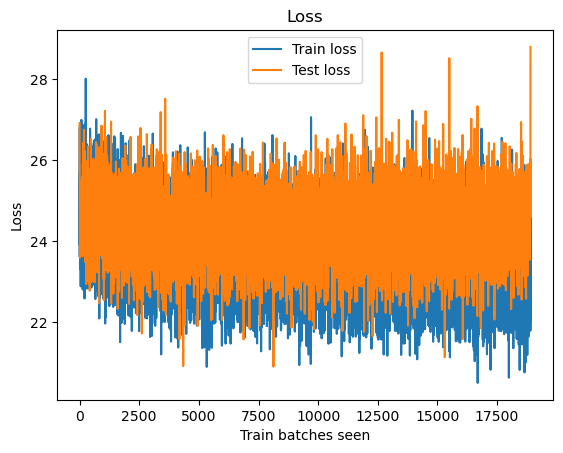

In [28]:
model = train_augmentation_transformer(data, dataset_name=dataset_name)

In [29]:
augmented_data = augment_data_transformer(model, data, close.shape[1])

100%|██████████| 142/142 [04:18<00:00,  1.82s/it]


In [30]:
augmented_data.shape

torch.Size([142, 14, 240])

In [31]:
data.shape

torch.Size([142, 14, 240])

In [32]:
torch.save(augmented_data, "fmri_old/aug_data_" + dataset_name + ".pt")

In [61]:
def plot_aug(real, aug, sub, net):
    print(np.corrcoef(aug[sub, :, net], real[sub, :, net])[0, 1])
    plt.figure(figsize=(15, 5))
    plt.plot(real[sub, :, net], label='real')
    plt.plot(aug[sub, :, net], label='aug')
    plt.legend()
    plt.title(f'Augmented data');
    plt.show()

In [62]:
augmented_data = augmented_data.reshape((augmented_data.shape[0], augmented_data.shape[2], augmented_data.shape[1]))
data = data.reshape((data.shape[0], data.shape[2], data.shape[1]))

-0.03574163471730684


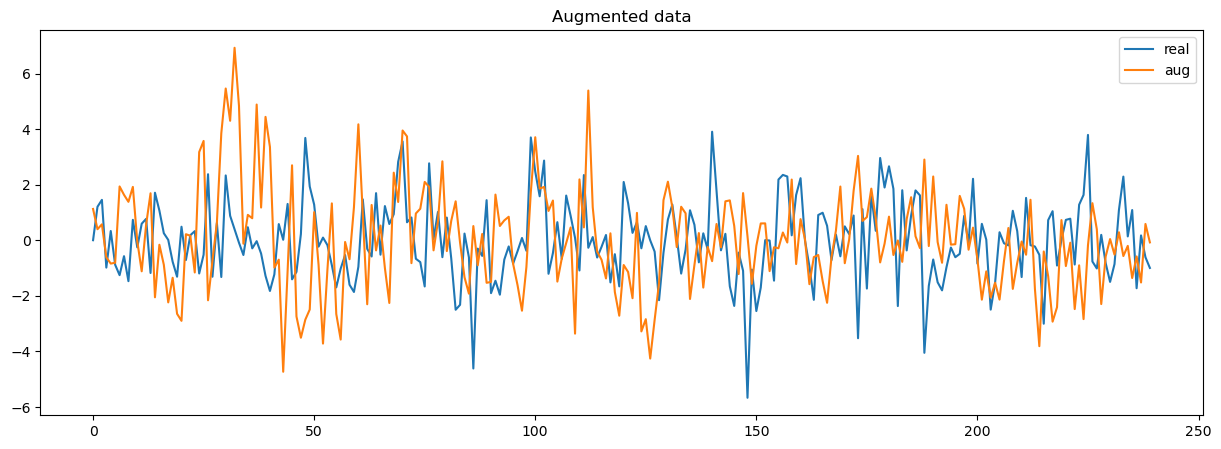

-6.589046177981132e-05


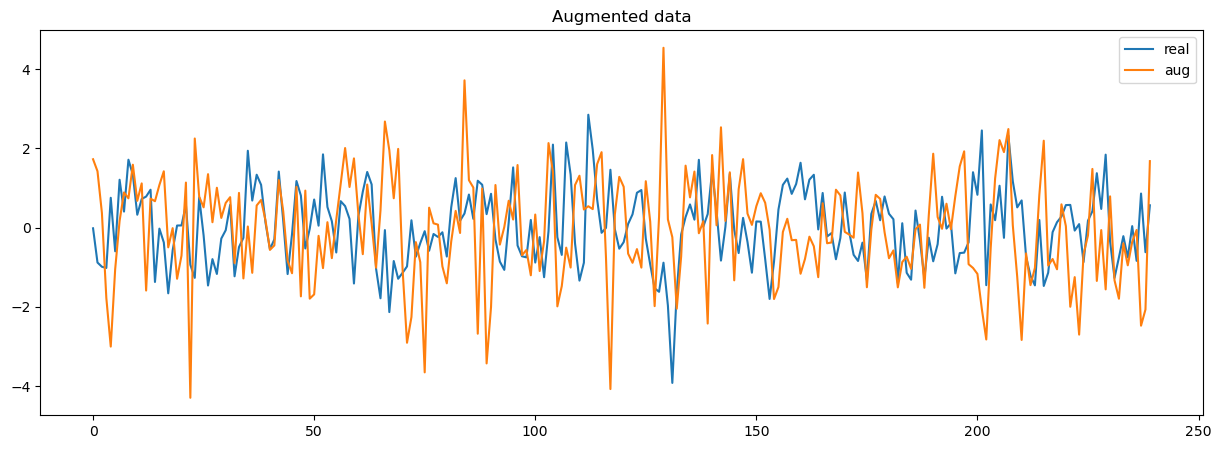

-0.11160325252696662


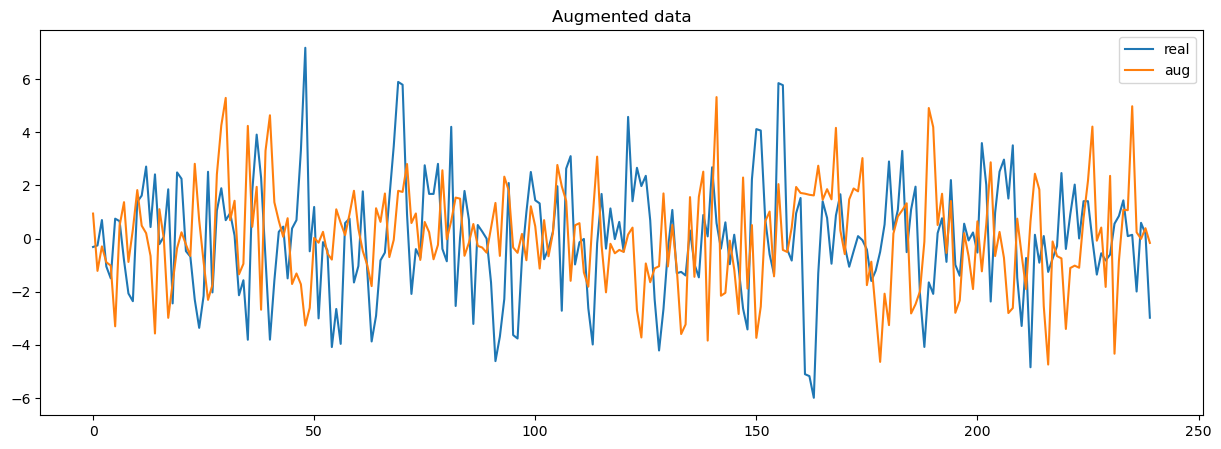

-0.02689187302505262


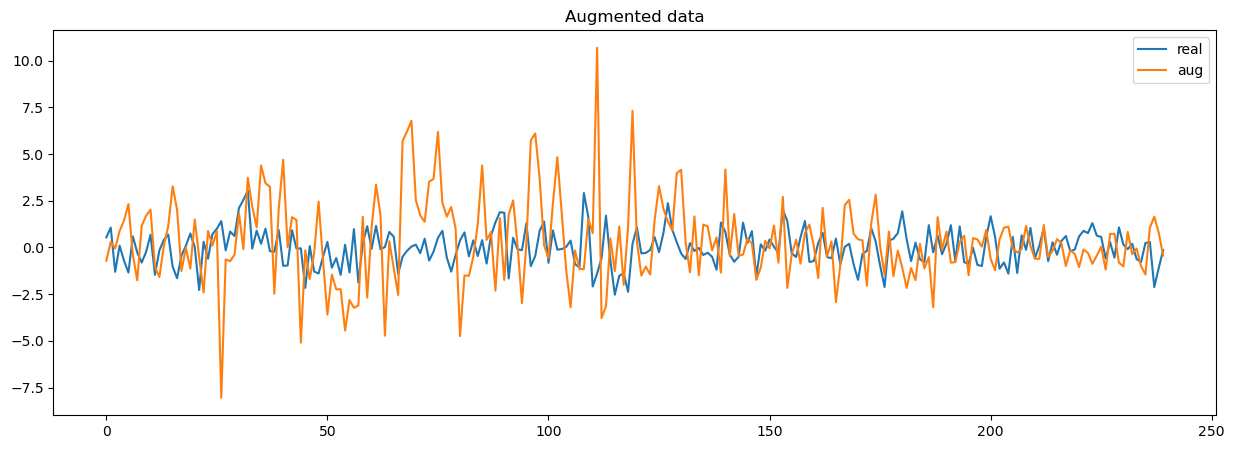

-0.09202442934642859


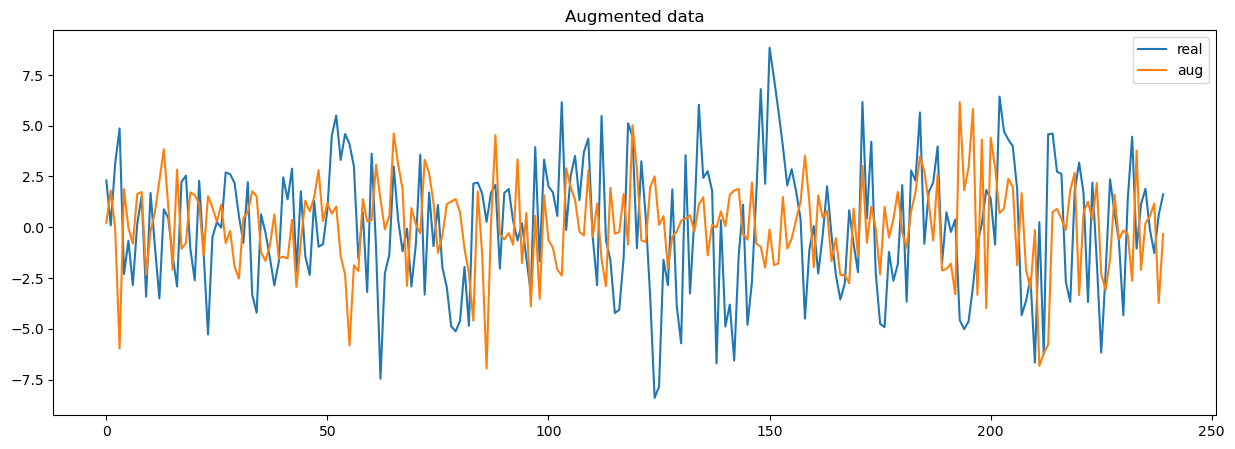

-0.08637322220375217


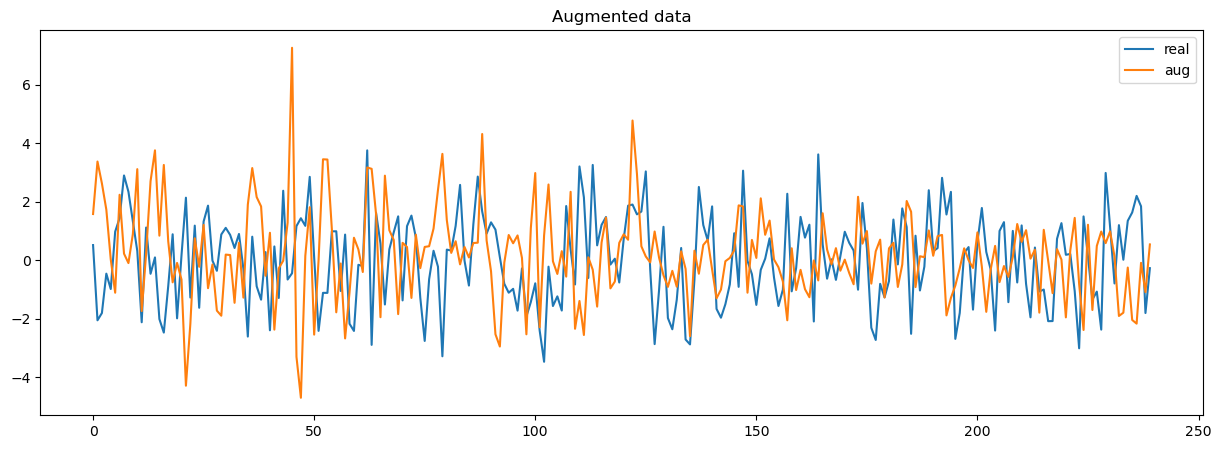

-0.055033859055401


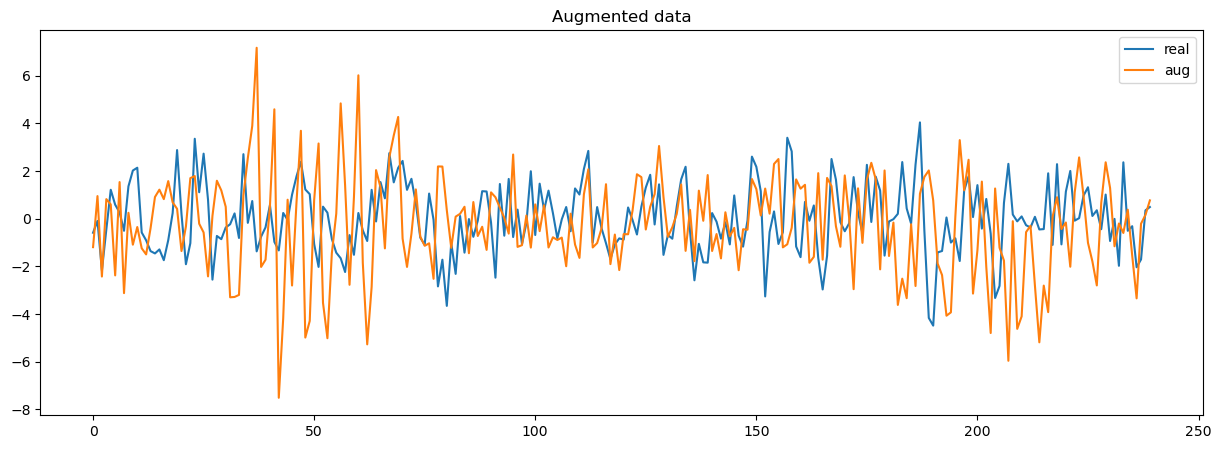

0.014309038747701735


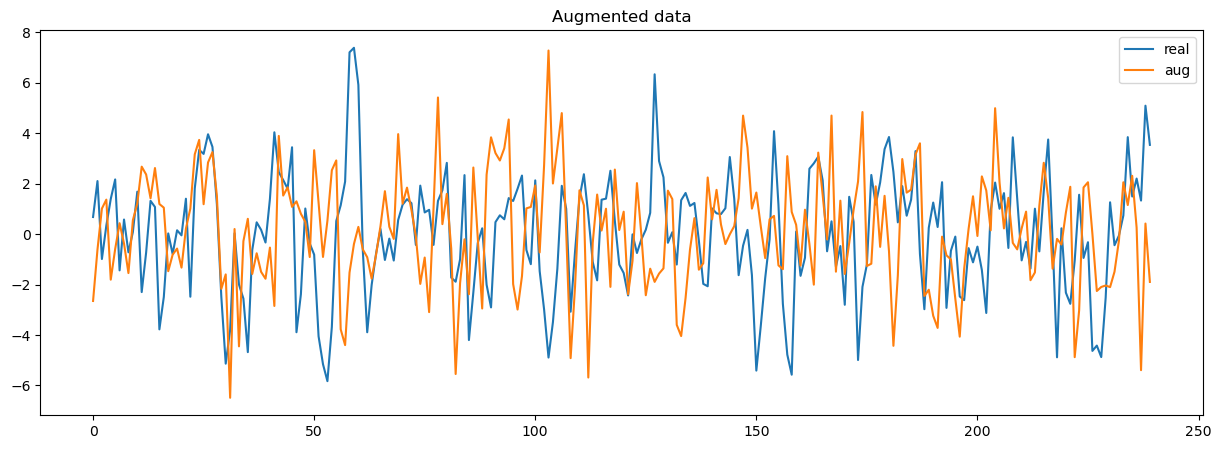

-0.04791198820106042


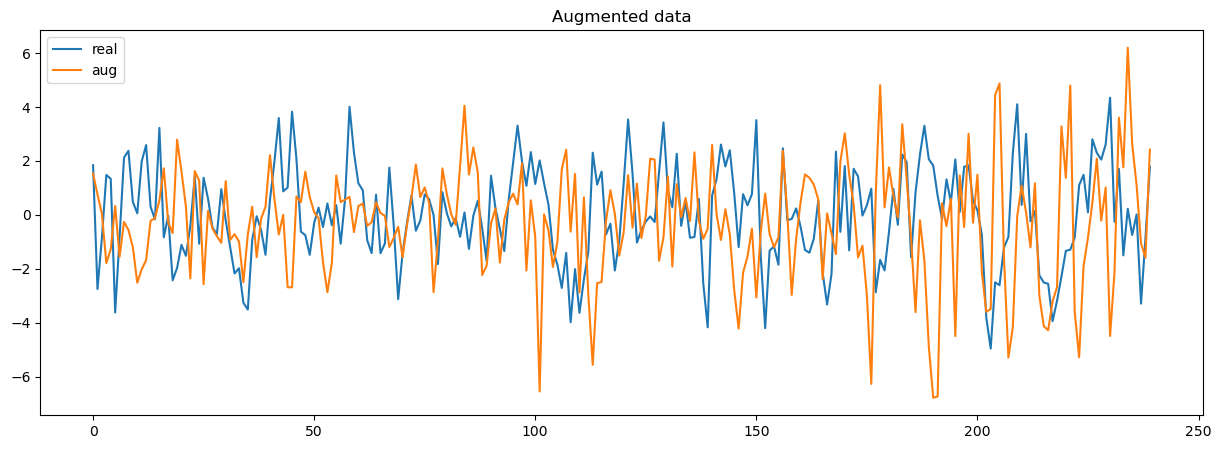

-0.047551171598827456


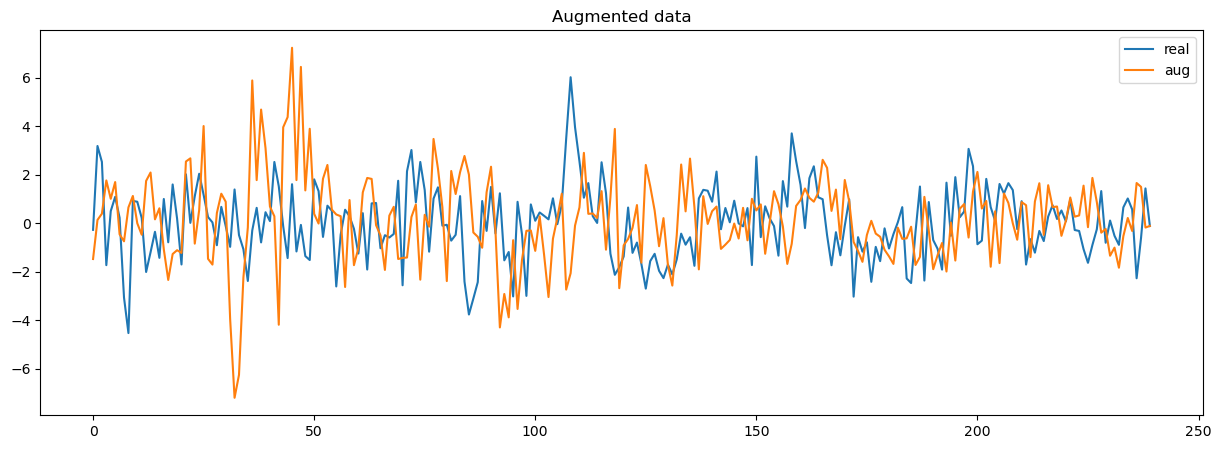

In [63]:
n_plots = 10

for _ in range(n_plots):
    sub = random.randint(0, data.shape[0] - 1)
    net = random.randint(0, data.shape[2] - 1)
    plot_aug(data, augmented_data, sub, net)